# Exploring Different Kernels

Now that I have a working model, let's explore different choices for kernels and what kinds of light curves they make:

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
import arviz as az

import numpy as np
import time as tsys

import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random

# TinyGP for Gaussian Processes, JaxNS and numpyro for sampling
from tinygp import GaussianProcess, kernels
from tinygp.kernels.quasisep import CARMA
import corner

from jaxns.utils import resample
import numpyro
import numpyro.distributions as dist
import numpyro.infer.autoguide as autoguide
from numpyro.infer import init_to_value

#stingray imports
import stingray
from stingray import Lightcurve, Powerspectrum


# suppress warnings
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../code/")
from models import skewgaussian

figdir = "../figures/"

INFO[2024-03-29 15:38:19,133]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1711723099.133642       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2024-03-29 15:38:19,134]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-03-29 15:38:19,138]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/danielahuppenkothen/work/sw/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed.

### Matern 3/2 Kernel

This is what we've started with: let's look at different light curves for different kernel parameters:

In [2]:
def simulate_mult_lightcurves(time, mean_func, mean_params, kernel_func, 
                                         kernel_params, log_const=None, log_bkg=None, key=None):
    """
    Function to simulate light curves as a product of the overall burst function 
    parametrized in `mean_func` and a Gaussian Process built using `kernel_func`.
    
    Any prescription for `mean_func` should take an array of `time` stamps and an 
    array `params` containing the parameters. Any `kernel_func` should take an array 
    of parameters for the kernel in question.
    
    Note that the `mean_func` is *not* actually the mean function of the Gaussian 
    Process, because we are setting up a multiplicative process. Don't confuse the two!
    
    Parameters
    ----------
    time : numpy.ndarray or JAX array
        Array with time stamps for the light curve
        
    mean_func : function
        The functional form for the burst function. This is not 
        actually the mean function for the GP, so don't confuse the two!
        
    mean_params : numpy.ndarray or JAX array
        A list of parameters for the mean model. Parameters are:
            * 'log_amp': log-amplitude of the skew-Gaussian
            * 't0': peak time of the skew-Gaussian
            * 'log_sig1': log rise timescale of the skew-Gaussian
            * 'log_sig2': log fall timescale of the skew-Gaussian
        
    kernel_func : function
        The functional form for the GP

    kernel_params
            * 'log_sigma': log-amplitude of the Matern 3/2 kernel
            * 'log_scale': log-timescale for the Matern 3/2 kernel
    
    log_const : float, default None
        If not `None`, the log-constant mean of the Gaussian Process.
        
    log_bkg : float, default None
        If not `None`, the log-constant background flux
        
    key : int, default None
        If not `None`, set random seed for ranom number generation,
        otherwise pick randomly.
        
    Returns
    -------
    lcsim : stingray.Lightcurve object
        The simulated light curve
        
    pssim : stingray.Powerspectrum object
        The periodogram of the simulated light curve
    
    exp_gp : JAX array
        The exponential of the GP sample used to generate the 
        variability
    """
    var_names = ["log_amp", "t0", "log_sig1", "log_sig2", "log_sigma", "log_scale"]

    # get params for skew_gaussian and calculate the mean
    mean_val = mean_func(time, mean_params)
    
    gp = kernel_func(time, kernel_params)

    if key is None:
        key = random.PRNGKey(np.random.randint(0,1e7))
    else:
        key = random.PRNGKey(key)

    # sample light curve from GP
    gp_sample = gp.sample(key)

    # calculate flux
    if log_const is None:
        exp_gp = jnp.exp(gp_sample) # exponentiated GP
    else:
        exp_gp = jnp.exp(gp_sample + jnp.exp(log_const)) # exponentiated GP

    #print(exp_gp)
    if log_bkg is None:
        flux = exp_gp * mean_val 
    else:
        flux = exp_gp * mean_val + jnp.exp(log_bkg)

    # poisson errors on flux
    counts = np.random.poisson(flux)

    lcsim = Lightcurve(time, counts, dt=time[1]-time[0], skip_checks=True)
    pssim = Powerspectrum(lcsim, norm="frac")

    return lcsim, pssim, exp_gp
    
    

Now let's make a function that sets up the GP for the Matern 3/2 kernel:

In [3]:
def build_matern32_gp(time, kernel_params):
    """
    Build a GP object using the Matern 3/2 kernel 
    from tinyGP's quasiseparable kernel package.
    
    Parameters
    ----------
    time : numpy.ndarray or JAX iterable
        An array with time stamps for evaluating the GP

    kernel_params : iterable
        An interable with the kernel parameters.
        Must be in the following order:
            * `log_sigma`: log-amplitude of the GP
            * `log_scale`: log-timescale of the variability
    
    Returns
    -------
    gp : tinygp.GaussianProcess object
        A GP object
    """
    log_sigma = kernel_params[0]
    log_scale = kernel_params[1]
    
    kernel = kernels.quasisep.Matern32(scale=jnp.exp(log_scale), 
                                       sigma=jnp.exp(log_sigma))

    # GP with constant function to generate random process
    gp = GaussianProcess(kernel, time, diag=0.01)

    return gp

Text(0, 0.5, 'Leahy-normalized Power')

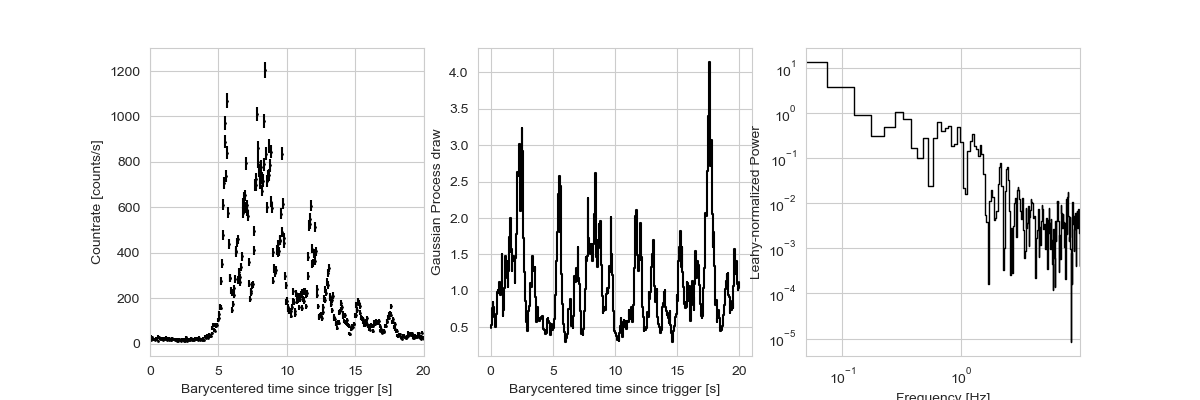

In [17]:
# Make a time array
dt = 0.05
tseg = 20.0
time = np.linspace(0, tseg, int(tseg/dt))


# make the kernel and set up GP
true_log_sigma = jnp.log(0.5)
true_log_scale = jnp.log(0.3)
kernel_params_true = [true_log_sigma, true_log_scale]

# set up the mean function
true_log_amp = jnp.log(500)
true_t0 = 6.0
true_log_sig1 = jnp.log(0.7)
true_log_sig2 = jnp.log(5.0)

mean_params_true = [true_log_amp, true_t0, true_log_sig1, true_log_sig2]
mean_val = skewgaussian(time, mean_params_true)

# parameter to set the absolute level of the GP mean
true_log_const = jnp.log(0.5)

# background flux
true_log_bkg = jnp.log(20.0)

lcsample, pssample, gp_sample = simulate_mult_lightcurves(time, skewgaussian, mean_params_true,
                                                          build_matern32_gp, kernel_params_true, 
                                                          log_bkg=true_log_bkg)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

ax1.errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
             fmt="o", markersize=1, color="black")
#ax1.plot(time, mean_val, lw=2, color="green")

ax1.set_xlim(lcsample.time[0], lcsample.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.plot(lcsample.time, gp_sample, color="black", ds="steps-mid")
ax2.set_xlabel("Barycentered time since trigger [s]")
ax2.set_ylabel("Gaussian Process draw")

ax3.loglog(pssample.freq, pssample.power, ds="steps-mid", lw=1, color="black")
#ax2.loglog(pssample.freq, ps_carma, lw=1, color="purple")
ax3.set_xlim(pssample.freq[0], pssample.freq[-1])
ax3.set_xlabel("Frequency [Hz]")
ax3.set_ylabel("Leahy-normalized Power")



Okay, let's make a grid of different kernel parameters and see how the bursts change:

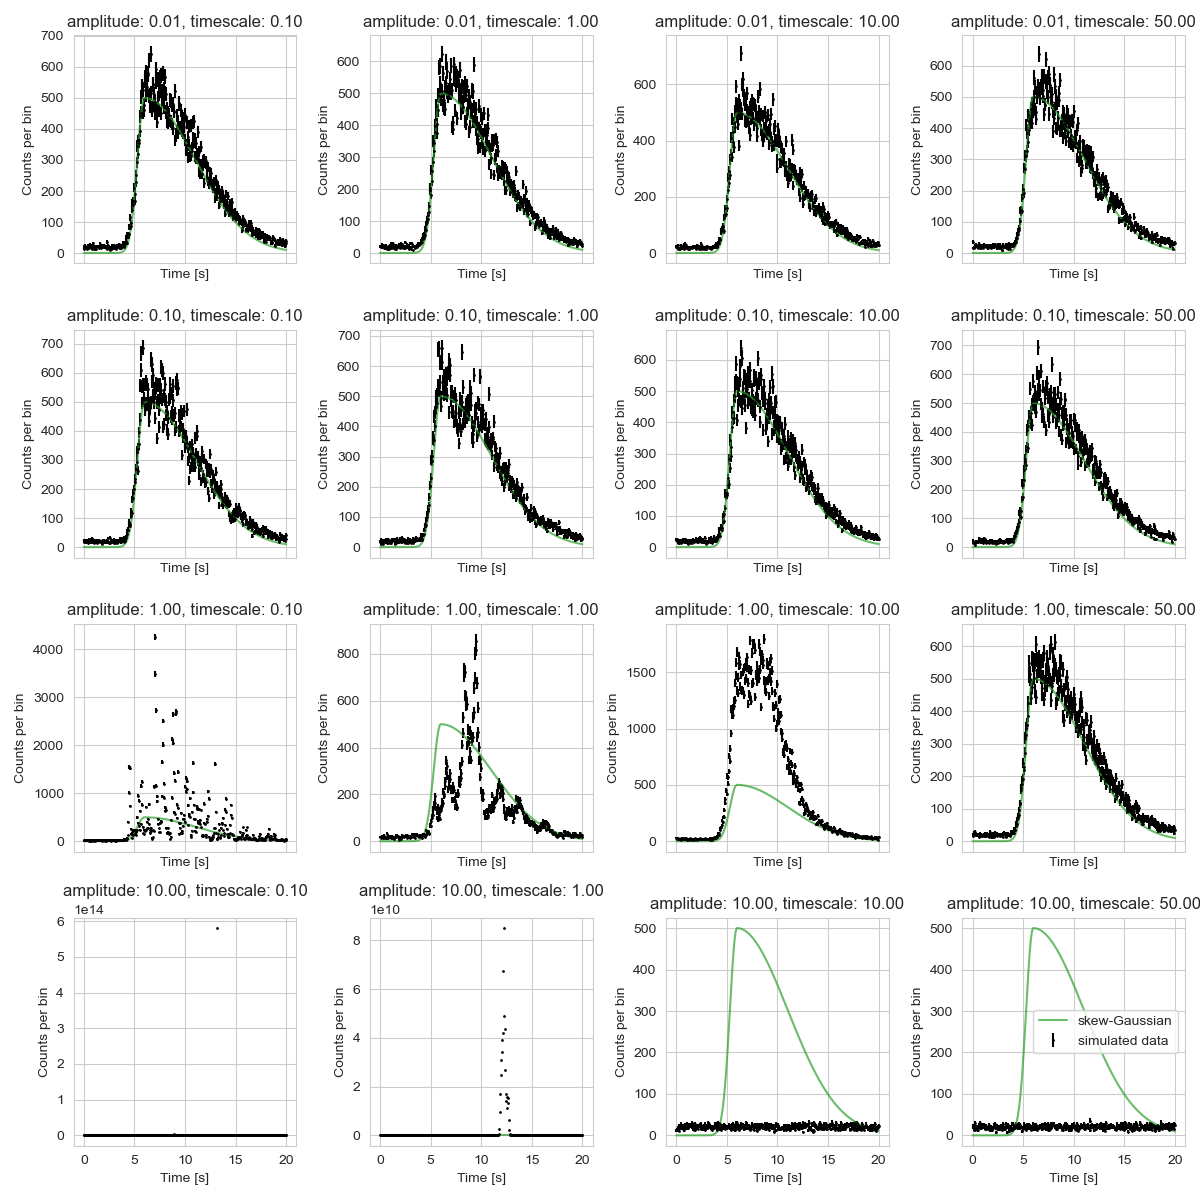

In [18]:
log_sigma = np.log([0.01, 0.1, 1.0, 10.0])
log_scale = np.log([0.1, 1.0, 10.0, 50])

nsigma = len(log_sigma)
nscale = len(log_scale)

# set up the mean function
true_log_amp = jnp.log(500)
true_t0 = 6.0
true_log_sig1 = jnp.log(0.7)
true_log_sig2 = jnp.log(5.0)

# background flux
true_log_bkg = jnp.log(20.0)

mean_params = [true_log_amp, true_t0, true_log_sig1, true_log_sig2]
mean_val = skewgaussian(time, mean_params_true)

# set up figure
fig, axes = plt.subplots(nsigma, nscale, figsize=(3*nsigma, 3*nscale), sharex=True)

lcsample_all, pssample_all, gpsample_all= [], [], []

for i, lsig in enumerate(log_sigma):
    for j, lsca in enumerate(log_scale):
        
        kernel_params = [lsig, lsca]
        lcsample, pssample, gp_sample = simulate_mult_lightcurves(time, skewgaussian, mean_params,
                                                                  build_matern32_gp, kernel_params, 
                                                                  log_bkg=true_log_bkg)

        lcsample_all.append(lcsample)
        pssample_all.append(pssample)
        gpsample_all.append(gp_sample)
        
        axes[i,j].errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
                           fmt="o", markersize=1, color="black", label="simulated data")
        axes[i,j].plot(lcsample.time, mean_val, color="C2", alpha=0.7, label="skew-Gaussian")
        axes[i,j].set_title("amplitude: {:.2f}, timescale: {:.2f}".format(jnp.exp(lsig), jnp.exp(lsca)))
        axes[i,j].set_xlabel("Time [s]")
        axes[i,j].set_ylabel("Counts per bin")
        
axes[-1, -1].legend()
fig.tight_layout()
fig.savefig(figdir + "mult_matern32_example_lcs.pdf", format="pdf")

### Matern 5/2 kernel

Let's repeat that using the Matern 5/2 kernel. We can basically copy a bunch of code:

In [19]:
def build_matern52_gp(time, kernel_params):
    """
    Build a GP object using the Matern 5/2 kernel 
    from tinyGP's quasiseparable kernel package.
    
    Parameters
    ----------
    time : numpy.ndarray or JAX iterable
        An array with time stamps for evaluating the GP

    kernel_params : iterable
        An interable with the kernel parameters.
        Must be in the following order:
            * `log_sigma`: log-amplitude of the GP
            * `log_scale`: log-timescale of the variability
    
    Returns
    -------
    gp : tinygp.GaussianProcess object
        A GP object
    """
    log_sigma = kernel_params[0]
    log_scale = kernel_params[1]
    
    kernel = kernels.quasisep.Matern52(scale=jnp.exp(log_scale), 
                                       sigma=jnp.exp(log_sigma))

    # GP with constant function to generate random process
    gp = GaussianProcess(kernel, time, diag=0.01)

    return gp

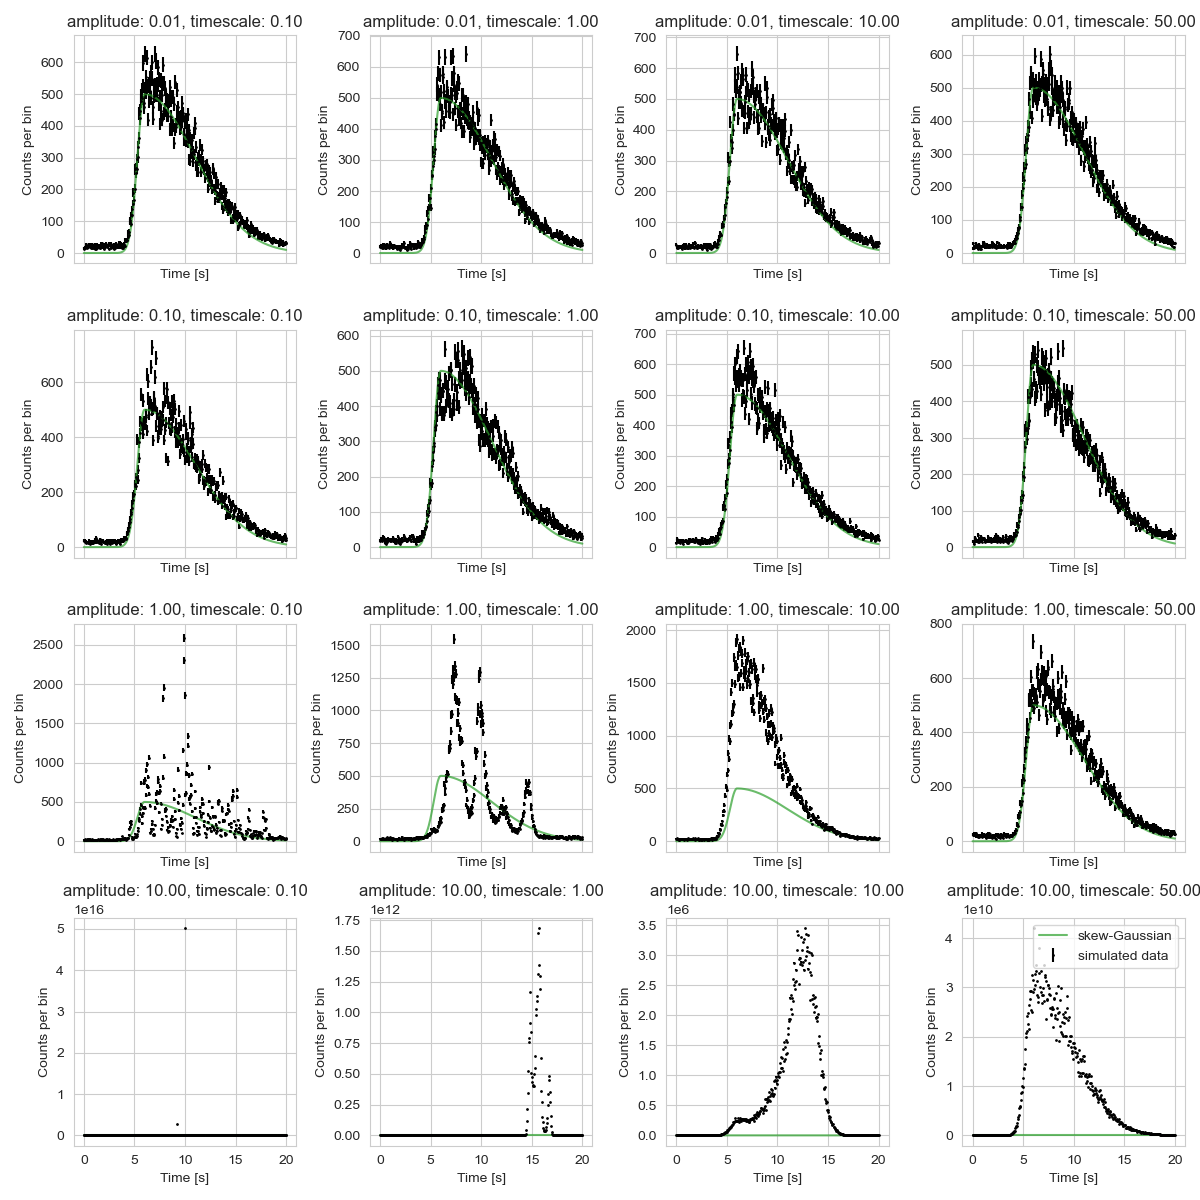

In [20]:
log_sigma = np.log([0.01, 0.1, 1.0, 10.0])
log_scale = np.log([0.1, 1.0, 10.0, 50])

nsigma = len(log_sigma)
nscale = len(log_scale)

# set up the mean function
true_log_amp = jnp.log(500)
true_t0 = 6.0
true_log_sig1 = jnp.log(0.7)
true_log_sig2 = jnp.log(5.0)

# background flux
true_log_bkg = jnp.log(20.0)

mean_params = [true_log_amp, true_t0, true_log_sig1, true_log_sig2]
mean_val = skewgaussian(time, mean_params_true)

# set up figure
fig, axes = plt.subplots(nsigma, nscale, figsize=(3*nsigma, 3*nscale), sharex=True)

lcsample_all, pssample_all, gpsample_all= [], [], []

for i, lsig in enumerate(log_sigma):
    for j, lsca in enumerate(log_scale):
        
        kernel_params = [lsig, lsca]
        lcsample, pssample, gp_sample = simulate_mult_lightcurves(time, skewgaussian, mean_params,
                                                                  build_matern52_gp, kernel_params, 
                                                                  log_bkg=true_log_bkg)

        lcsample_all.append(lcsample)
        pssample_all.append(pssample)
        gpsample_all.append(gp_sample)
        
        axes[i,j].errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
                           fmt="o", markersize=1, color="black", label="simulated data")
        axes[i,j].plot(lcsample.time, mean_val, color="C2", alpha=0.7, label="skew-Gaussian")
        axes[i,j].set_title("amplitude: {:.2f}, timescale: {:.2f}".format(jnp.exp(lsig), jnp.exp(lsca)))
        axes[i,j].set_xlabel("Time [s]")
        axes[i,j].set_ylabel("Counts per bin")
        
axes[-1, -1].legend()
fig.tight_layout()
fig.savefig(figdir + "mult_matern52_example_lcs.pdf", format="pdf")

## Squared Exponential Covariance Function

And what about a Squared Exponential Covariance function?

In [21]:
def build_expsquared_gp(time, kernel_params):
    """
    Build a GP object using the Matern Squared 
    Exponential kernel, the standard GP kernel 
    everyone uses, from tinyGP
    
    Parameters
    ----------
    time : numpy.ndarray or JAX iterable
        An array with time stamps for evaluating the GP

    kernel_params : iterable
        An interable with the kernel parameters.
        Must be in the following order:
            * `log_sigma`: log-amplitude of the GP
            * `log_scale`: log-timescale of the variability
    
    Returns
    -------
    gp : tinygp.GaussianProcess object
        A GP object
    """
    log_sigma = kernel_params[0]
    log_scale = kernel_params[1]
    
    kernel = jnp.exp(log_sigma)*kernels.ExpSquared(scale=jnp.exp(log_scale))

    # GP with constant function to generate random process
    gp = GaussianProcess(kernel, time, diag=0.01)

    return gp

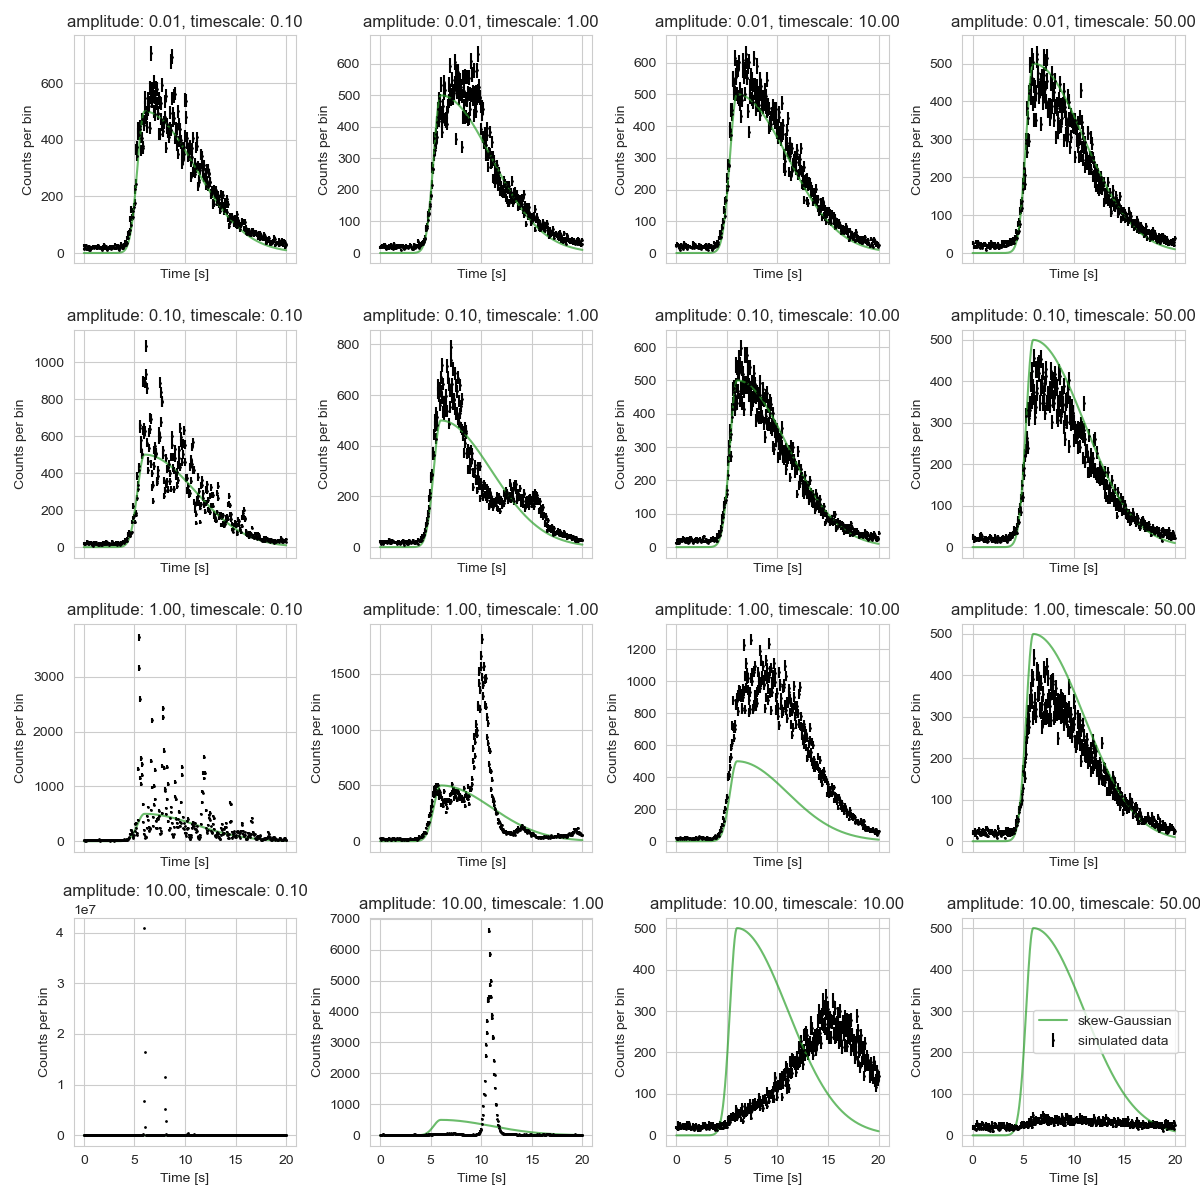

In [22]:
log_sigma = np.log([0.01, 0.1, 1.0, 10.0])
log_scale = np.log([0.1, 1.0, 10.0, 50])

nsigma = len(log_sigma)
nscale = len(log_scale)

# set up the mean function
true_log_amp = jnp.log(500)
true_t0 = 6.0
true_log_sig1 = jnp.log(0.7)
true_log_sig2 = jnp.log(5.0)

# background flux
true_log_bkg = jnp.log(20.0)

mean_params = [true_log_amp, true_t0, true_log_sig1, true_log_sig2]
mean_val = skewgaussian(time, mean_params_true)

# set up figure
fig, axes = plt.subplots(nsigma, nscale, figsize=(3*nsigma, 3*nscale), sharex=True)

lcsample_all, pssample_all, gpsample_all= [], [], []

for i, lsig in enumerate(log_sigma):
    for j, lsca in enumerate(log_scale):
        
        kernel_params = [lsig, lsca]
        lcsample, pssample, gp_sample = simulate_mult_lightcurves(time, skewgaussian, mean_params,
                                                                  build_expsquared_gp, kernel_params, 
                                                                  log_bkg=true_log_bkg)

        lcsample_all.append(lcsample)
        pssample_all.append(pssample)
        gpsample_all.append(gp_sample)
        
        axes[i,j].errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
                           fmt="o", markersize=1, color="black", label="simulated data")
        axes[i,j].plot(lcsample.time, mean_val, color="C2", alpha=0.7, label="skew-Gaussian")
        axes[i,j].set_title("amplitude: {:.2f}, timescale: {:.2f}".format(jnp.exp(lsig), jnp.exp(lsca)))
        axes[i,j].set_xlabel("Time [s]")
        axes[i,j].set_ylabel("Counts per bin")
        
axes[-1, -1].legend()
fig.tight_layout()
fig.savefig(figdir + "mult_expsquared_example_lcs.pdf", format="pdf")

## Damped Random Walk 

Because astronomers love it, how about a Damped Random Walk?

In [23]:
def build_drw_gp(time, kernel_params):
    """
    Build a GP object using a Damped Random Walk (DRW)
    kernel from tinyGP's quasiseparable kernel package.
    Corresponds to a CARMA(1,0) process or a simple
    exponential kernel.
    
    Parameters
    ----------
    time : numpy.ndarray or JAX iterable
        An array with time stamps for evaluating the GP

    kernel_params : iterable
        An interable with the kernel parameters.
        Must be in the following order:
            * `log_sigma`: log-amplitude of the GP
            * `log_scale`: log-timescale of the variability
    
    Returns
    -------
    gp : tinygp.GaussianProcess object
        A GP object
    """
    log_sigma = kernel_params[0]
    log_scale = kernel_params[1]
    
    kernel = kernels.quasisep.Exp(scale=np.exp(log_scale), sigma=jnp.exp(log_sigma))

    # GP with constant function to generate random process
    gp = GaussianProcess(kernel, time, diag=0.01)

    return gp

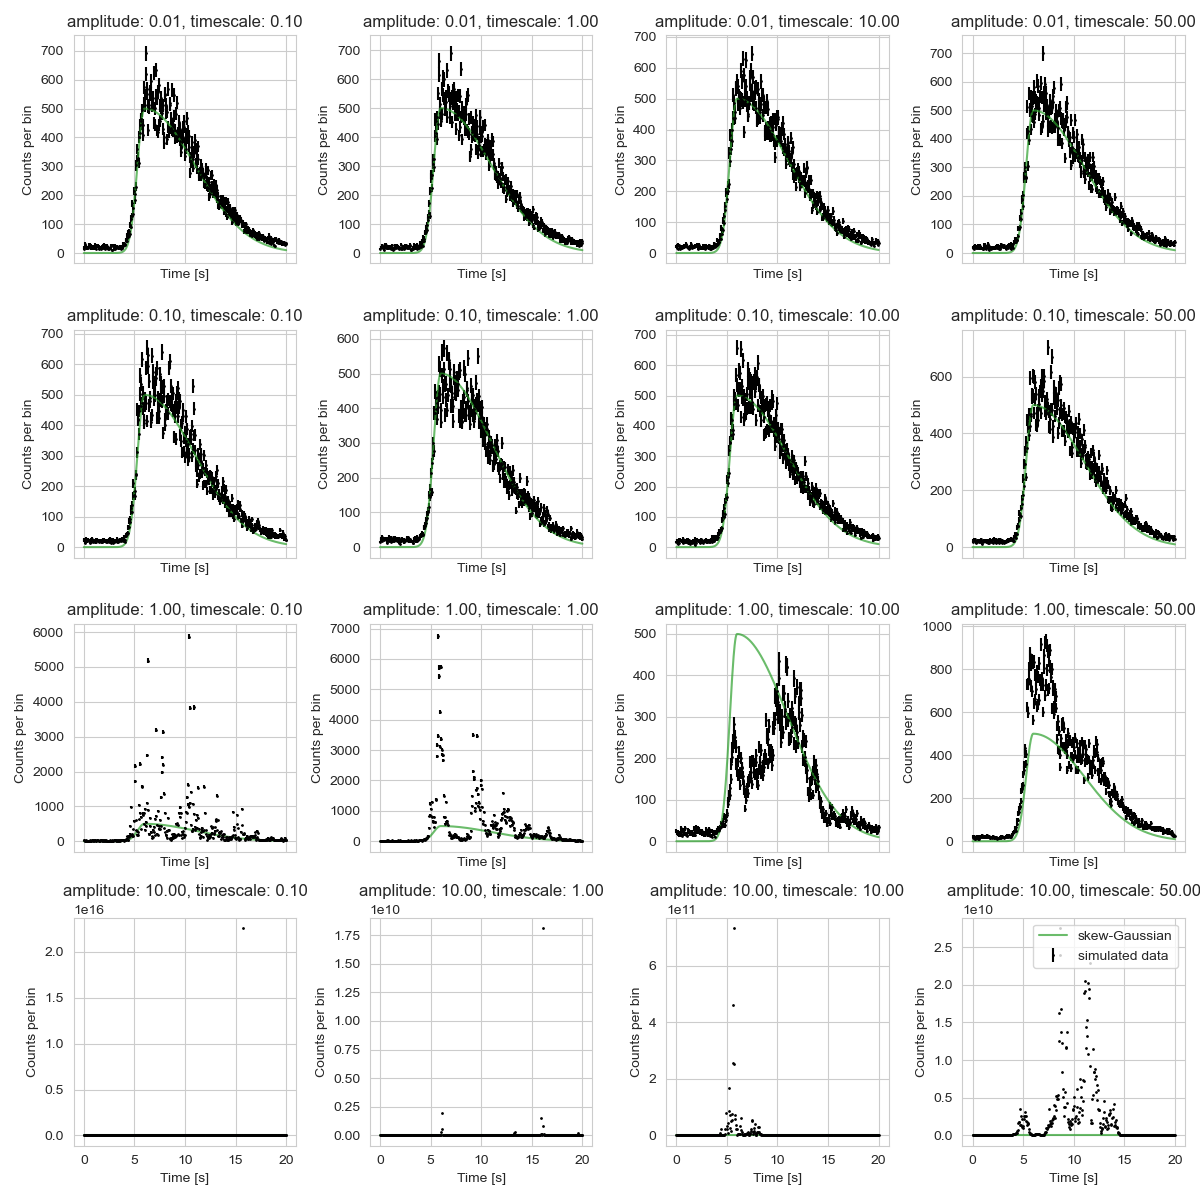

In [24]:
log_sigma = np.log([0.01, 0.1, 1.0, 10.0])
log_scale = np.log([0.1, 1.0, 10.0, 50])

nsigma = len(log_sigma)
nscale = len(log_scale)

# set up the mean function
true_log_amp = jnp.log(500)
true_t0 = 6.0
true_log_sig1 = jnp.log(0.7)
true_log_sig2 = jnp.log(5.0)

# background flux
true_log_bkg = jnp.log(20.0)

mean_params = [true_log_amp, true_t0, true_log_sig1, true_log_sig2]
mean_val = skewgaussian(time, mean_params_true)

# set up figure
fig, axes = plt.subplots(nsigma, nscale, figsize=(3*nsigma, 3*nscale), sharex=True)

lcsample_all, pssample_all, gpsample_all= [], [], []

for i, lsig in enumerate(log_sigma):
    for j, lsca in enumerate(log_scale):
        
        kernel_params = [lsig, lsca]
        lcsample, pssample, gp_sample = simulate_mult_lightcurves(time, skewgaussian, mean_params,
                                                                  build_drw_gp, kernel_params, 
                                                                  log_bkg=true_log_bkg)

        lcsample_all.append(lcsample)
        pssample_all.append(pssample)
        gpsample_all.append(gp_sample)
        
        axes[i,j].errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
                           fmt="o", markersize=1, color="black", label="simulated data")
        axes[i,j].plot(lcsample.time, mean_val, color="C2", alpha=0.7, label="skew-Gaussian")
        axes[i,j].set_title("amplitude: {:.2f}, timescale: {:.2f}".format(jnp.exp(lsig), jnp.exp(lsca)))
        axes[i,j].set_xlabel("Time [s]")
        axes[i,j].set_ylabel("Counts per bin")
        
axes[-1, -1].legend()
fig.tight_layout()
fig.savefig(figdir + "mult_drw_example_lcs.pdf", format="pdf")

## CARMA(2,1) Process

How about a CARMA(2,1) process as comparison?

In [25]:
def build_carma21_gp(time, kernel_params):
    """
    Build a GP object using the Matern 3/2 kernel 
    from tinyGP's quasiseparable kernel package.
    
    Parameters
    ----------
    time : numpy.ndarray or JAX iterable
        An array with time stamps for evaluating the GP

    kernel_params : iterable
        An interable with the kernel parameters.
        Must be in the following order:
            * `log_alpha1`: first of the two autoregressive parameters
            * `log_alpha2`: second of the two autoregressive parameters
            * `log_beta`: moving average parameter, contains amplitude
    
    Returns
    -------
    gp : tinygp.GaussianProcess object
        A GP object
    """
    alpha = jnp.exp(np.array([kernel_params[0], kernel_params[1]]))
    beta = [jnp.exp(kernel_params[2])]
    
    kernel = CARMA.init(alpha=alpha, beta=beta)
    
    # GP with constant function to generate random process
    gp = GaussianProcess(kernel, time, diag=0.01)

    return gp

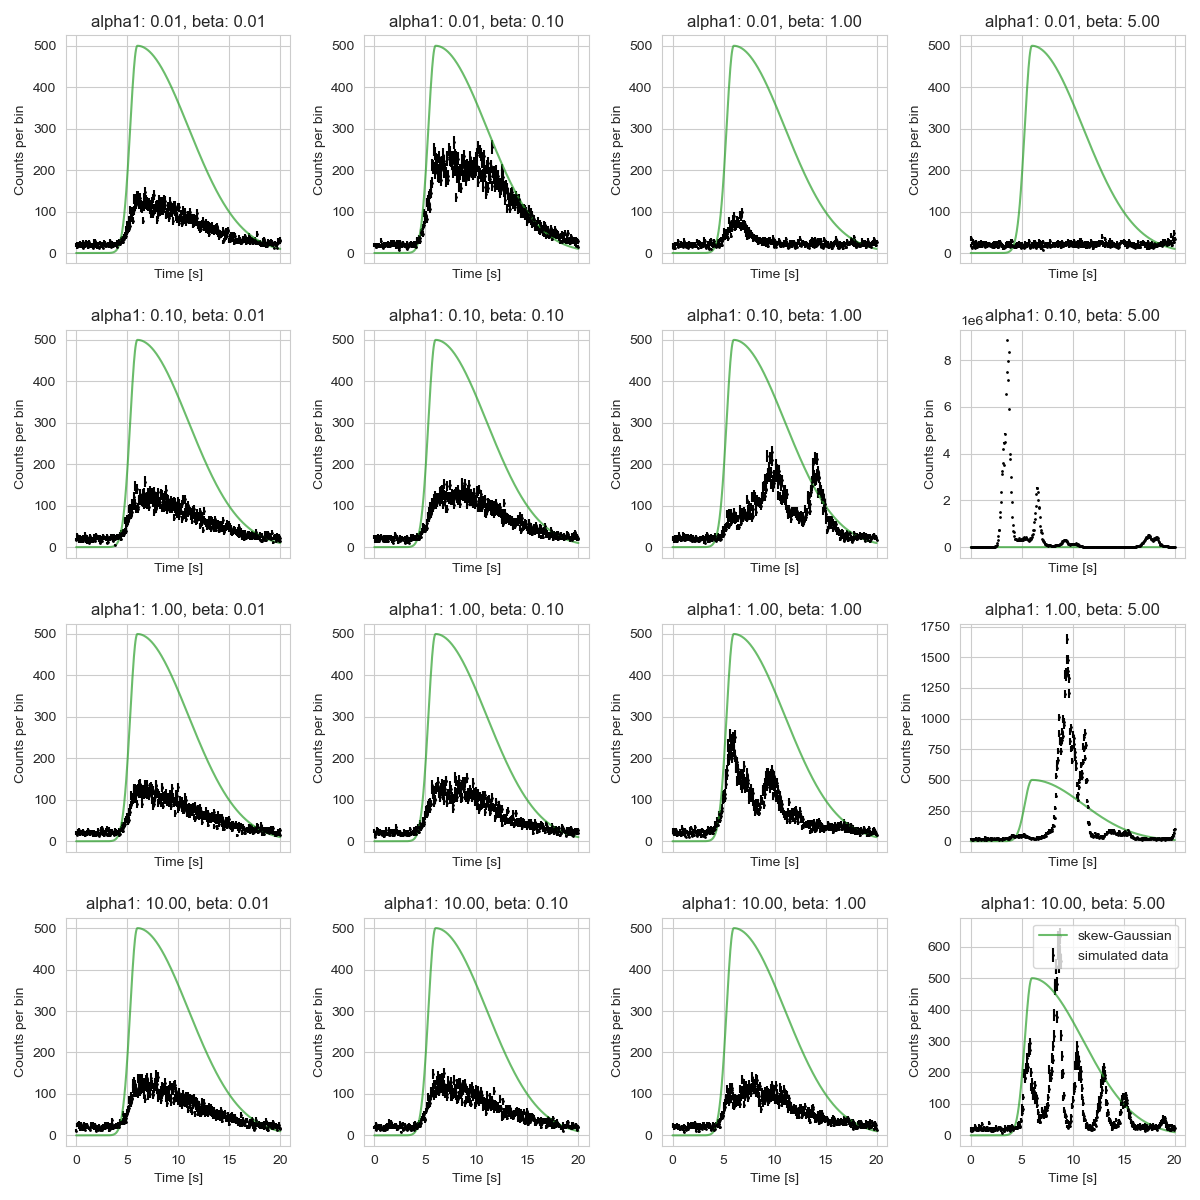

In [27]:
log_alpha1 = np.log([0.01, 0.1, 1.0, 10.0])
log_alpha2 = np.log(1.0)
log_beta = np.log([0.01, 0.1, 1.0, 5])

nsigma = len(log_sigma)
nscale = len(log_scale)

# set up the mean function
true_log_amp = jnp.log(100)
true_t0 = 6.0
true_log_sig1 = jnp.log(0.7)
true_log_sig2 = jnp.log(5.0)

# background flux
true_log_bkg = jnp.log(20.0)

mean_params = [true_log_amp, true_t0, true_log_sig1, true_log_sig2]
mean_val = skewgaussian(time, mean_params_true)

# set up figure
fig, axes = plt.subplots(nsigma, nscale, figsize=(3*nsigma, 3*nscale), sharex=True)

lcsample_all, pssample_all, gpsample_all= [], [], []

for i, lalpha in enumerate(log_alpha1):
    for j, lbeta in enumerate(log_beta):
        
        try:
            kernel_params = [lalpha, log_alpha2, lbeta]
            lcsample, pssample, gp_sample = simulate_mult_lightcurves(time, skewgaussian, mean_params,
                                                                      build_carma21_gp, kernel_params, 
                                                                      log_bkg=true_log_bkg)
        except ValueError:
            print(f"ValueError for i = {i}, j = {j}")
            continue
        lcsample_all.append(lcsample)
        pssample_all.append(pssample)
        gpsample_all.append(gp_sample)
        
        axes[i,j].errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
                           fmt="o", markersize=1, color="black", label="simulated data")
        axes[i,j].plot(lcsample.time, mean_val, color="C2", alpha=0.7, label="skew-Gaussian")
        axes[i,j].set_title("alpha1: {:.2f}, beta: {:.2f}".format(jnp.exp(lalpha), jnp.exp(lbeta)))
        axes[i,j].set_xlabel("Time [s]")
        axes[i,j].set_ylabel("Counts per bin")
        
axes[-1, -1].legend()
fig.tight_layout()
fig.savefig(figdir + "mult_carma21_example_lcs.pdf", format="pdf")

What if I keep beta fixed, and just change alpha1 and alpha2?

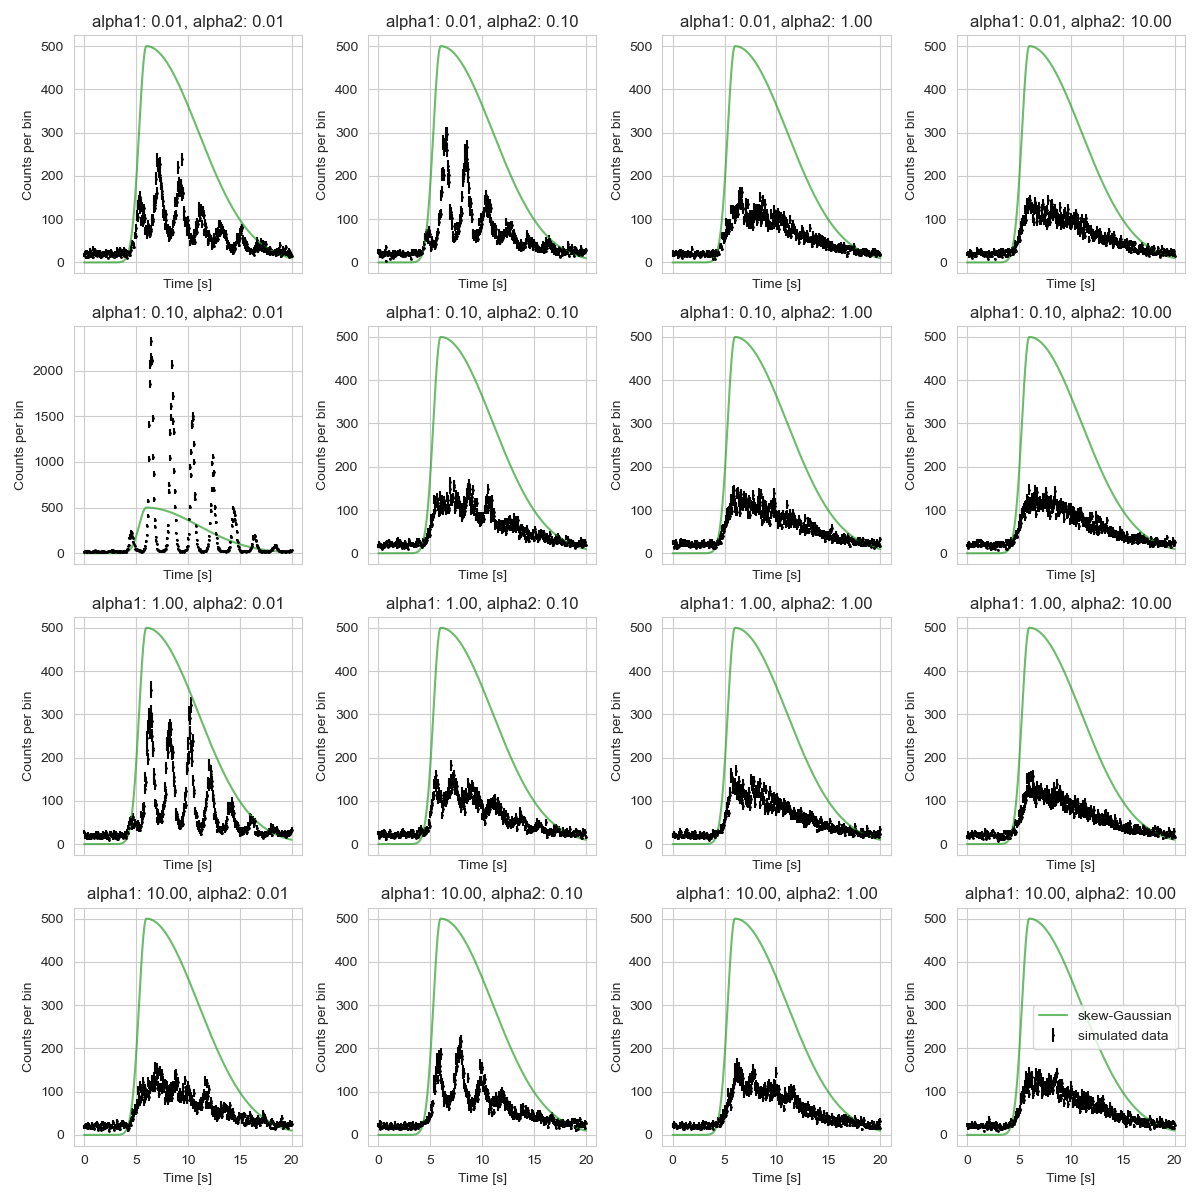

In [42]:
log_alpha1 = np.log([0.01, 0.1, 1.0, 10.0])
log_alpha2 = np.log([0.01, 0.1, 1.0, 10.0])
log_beta = np.log(0.5)

nsigma = len(log_sigma)
nscale = len(log_scale)

# set up the mean function
true_log_amp = jnp.log(100)
true_t0 = 6.0
true_log_sig1 = jnp.log(0.7)
true_log_sig2 = jnp.log(5.0)

# background flux
true_log_bkg = jnp.log(20.0)

mean_params = [true_log_amp, true_t0, true_log_sig1, true_log_sig2]
mean_val = skewgaussian(time, mean_params_true)

# set up figure
fig, axes = plt.subplots(nsigma, nscale, figsize=(3*nsigma, 3*nscale), sharex=True)

lcsample_all, pssample_all, gpsample_all= [], [], []

for i, lalpha1 in enumerate(log_alpha1):
    for j, lalpha2 in enumerate(log_alpha2):
        
        try:
            kernel_params = [lalpha, lalpha2, log_beta]
            lcsample, pssample, gp_sample = simulate_mult_lightcurves(time, skewgaussian, mean_params,
                                                                      build_carma21_gp, kernel_params, 
                                                                      log_bkg=true_log_bkg)
        except ValueError:
            print(f"ValueError for i = {i}, j = {j}")
            continue
        lcsample_all.append(lcsample)
        pssample_all.append(pssample)
        gpsample_all.append(gp_sample)
        
        axes[i,j].errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
                           fmt="o", markersize=1, color="black", label="simulated data")
        axes[i,j].plot(lcsample.time, mean_val, color="C2", alpha=0.7, label="skew-Gaussian")
        axes[i,j].set_title("alpha1: {:.2f}, alpha2: {:.2f}".format(jnp.exp(lalpha1), jnp.exp(lalpha2)))
        axes[i,j].set_xlabel("Time [s]")
        axes[i,j].set_ylabel("Counts per bin")
        
axes[-1, -1].legend()
fig.tight_layout()
fig.savefig(figdir + "mult_carma21_example2_lcs.pdf", format="pdf")

That surely has a bunch of periodicities in it? Let's check the real and theoretically expected PSD for some of those. First, I need a couple of function that will calculate the expected PSD given the parameters:

In [39]:
def get_ar_roots(qpo_width, qpo_centroid):
    """
    Return the roots of the characteristic AR(p) polynomial of the CARMA(p,q) process, given the lorentzian widths and
    centroids.

    :rtype : The roots of the autoregressive polynomial, a numpy array.
    :param qpo_width: The widths of the lorentzian functions defining the PSD.
    :param qpo_centroid: The centroids of the lorentzian functions defining the PSD. For all values of qpo_centroid
         that are greater than zero, the complex conjugate of the root will also be added.
    """
    ar_roots = []
    for i in range(len(qpo_centroid)):
        ar_roots.append(qpo_width[i] + 1j * qpo_centroid[i])
        if qpo_centroid[i] > 1e-10:
            # lorentzian is centered at a frequency > 0, so add complex conjugate of this root
            ar_roots.append(np.conjugate(ar_roots[-1]))
    if len(qpo_width) - len(qpo_centroid) == 1:
        # odd number of lorentzian functions, so add in low-frequency component
        ar_roots.append(qpo_width[-1] + 1j * 0.0)
    ar_roots = np.array(ar_roots)

    return -2.0 * np.pi * ar_roots

def power_spectrum(freq, ar_coef, ma_coefs=[1.0]):
    """
    FROM CARMApack (Kelly et al, 2014)
    
    Return the power spectrum for a CARMA(p,q) process calculated at the input frequencies.

    :param freq: The frequencies at which to calculate the PSD.
    :param sigma: The standard deviation driving white noise.
    :param ar_coef: The CARMA model autoregressive coefficients.
    :param ma_coefs: Coefficients of the moving average polynomial

    :rtype : The power spectrum at the input frequencies, a numpy array.
    """
    try:
        len(ma_coefs) <= len(ar_coef)
    except ValueError:
        "Size of ma_coefs must be less or equal to size of ar_roots."

    ma_poly = np.polyval(ma_coefs[::-1], 2.0 * np.pi * 1j * freq)  # Evaluate the polynomial in the PSD numerator
    ar_poly = np.polyval(ar_coef, 2.0 * np.pi * 1j * freq)  # Evaluate the polynomial in the PSD denominator
    pspec = np.abs(ma_poly) ** 2 / np.abs(ar_poly) ** 2
    return pspec

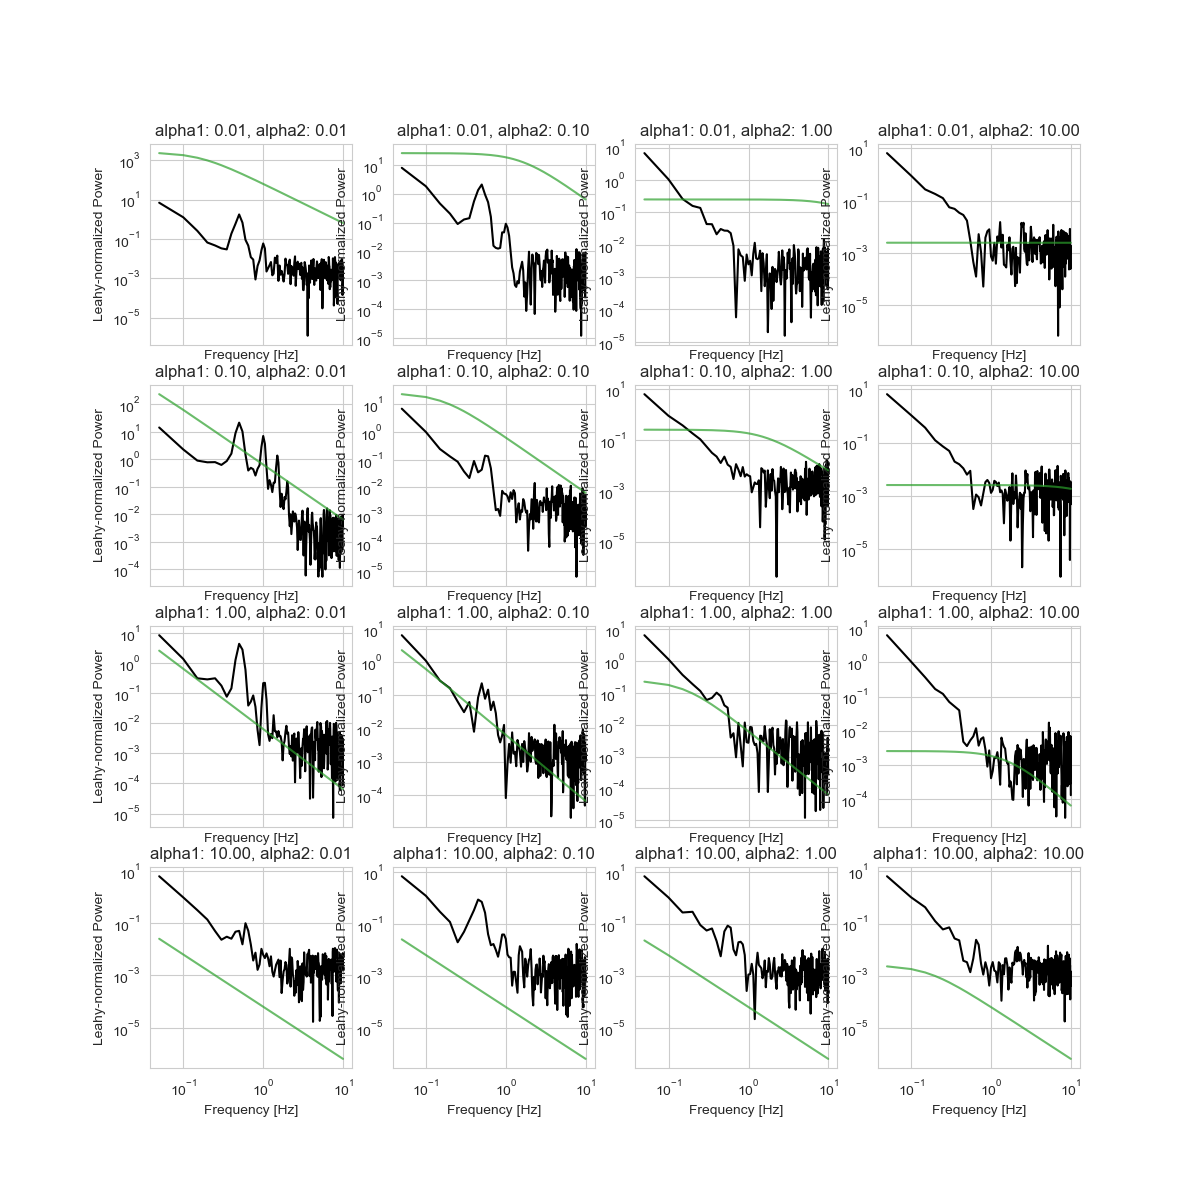

In [43]:
fig, axes = plt.subplots(nsigma, nscale, figsize=(3*nsigma, 3*nscale), sharex=True)

for i, lalpha1 in enumerate(log_alpha1):
    for j, lalpha2 in enumerate(log_alpha2):
        k = i*nsigma + j
        lcsample = lcsample_all[k]
        pssample = pssample_all[k]
        gp_sample = gpsample_all[k]

        alpha = np.exp([lalpha1, lalpha2])
        beta = [np.exp(log_beta)]

        pspec = power_spectrum(pssample.freq, alpha, beta)
        
        axes[i,j].loglog(pssample.freq, pssample.power, color="black", label="simulated data")
        axes[i,j].plot(pssample.freq, pspec, color="C2", alpha=0.7, label="expected PSD")
        axes[i,j].set_title("alpha1: {:.2f}, alpha2: {:.2f}".format(jnp.exp(lalpha1), jnp.exp(lalpha2)))
        axes[i,j].set_xlabel("Frequency [Hz]")
        axes[i,j].set_ylabel("Leahy-normalized Power")
        

Well, that doesn't look super great, and I don't know why. Let's put a pin in that until I need more CARMA models. Maybe I can use Mehdy's code to make that work better.

## Comparison of different kernels

Let's run a comparison of different kernels. I'm going to fix the amplitude (sigma), and run comparisons for different values of the scale:

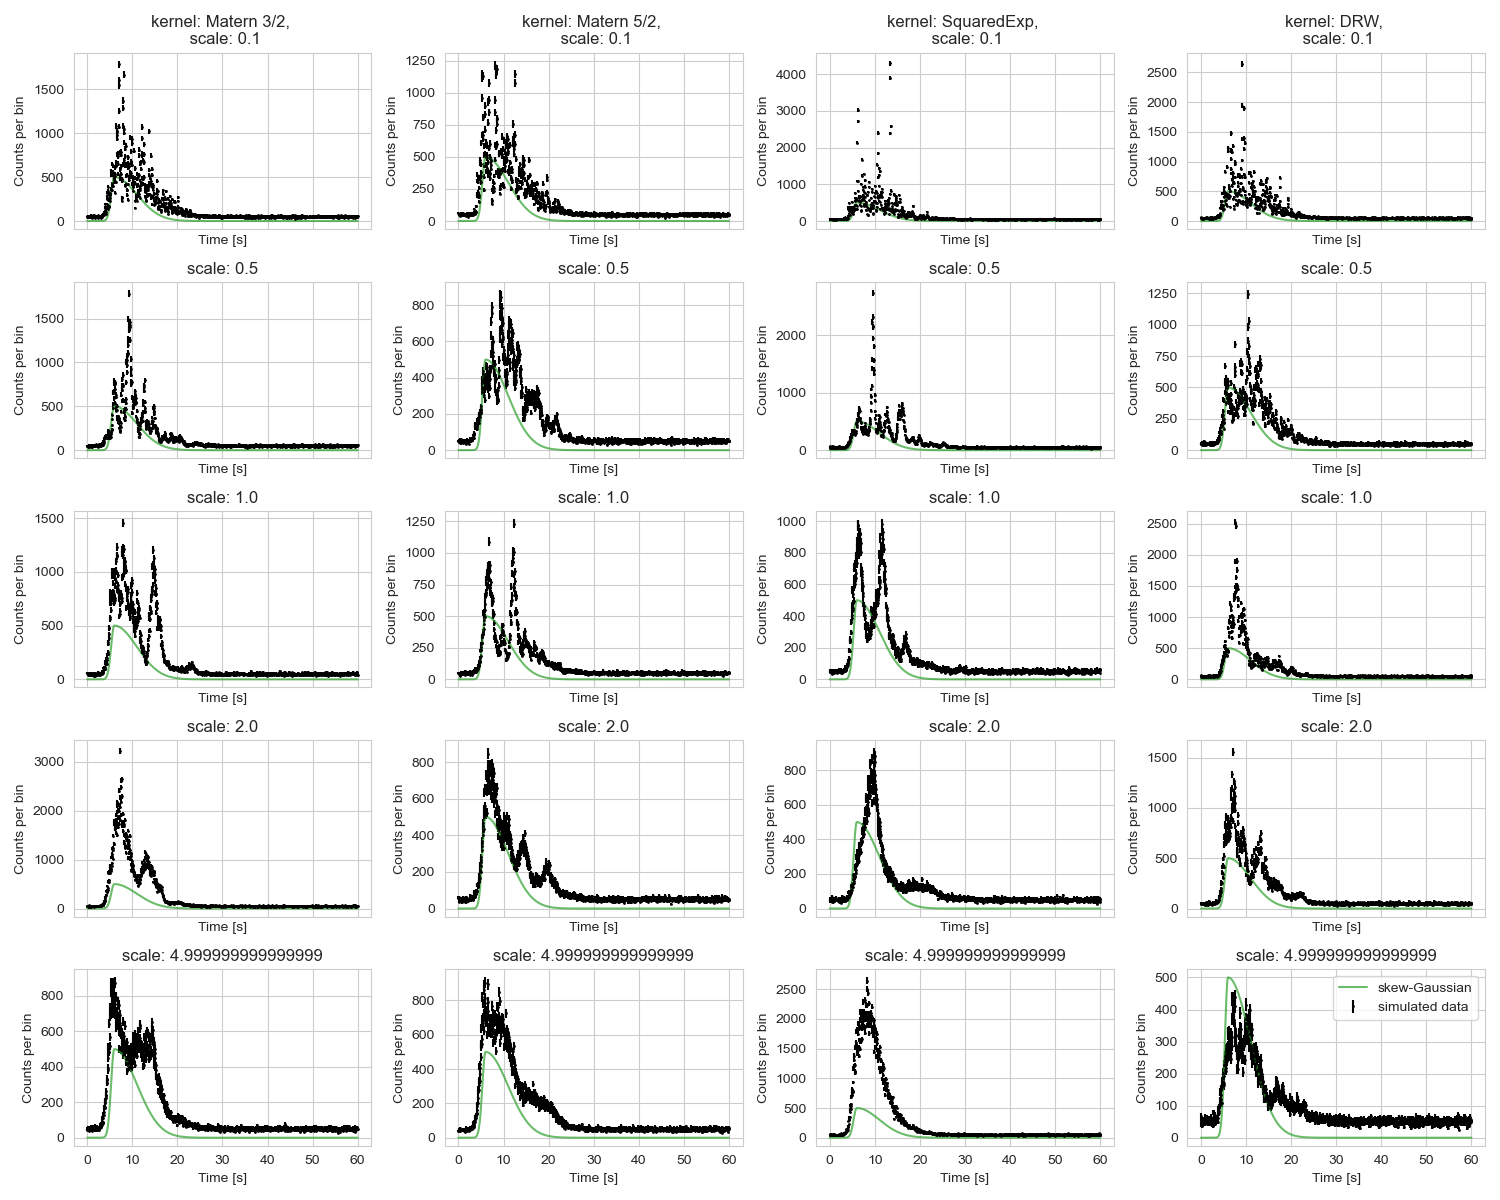

In [52]:
# Make a time array
dt = 0.05
tseg = 60.0
time = np.linspace(0, tseg, int(tseg/dt))


# different kernels to compare
kernel_func = [build_matern32_gp, build_matern52_gp, build_expsquared_gp, build_drw_gp]
kernel_names = ["Matern 3/2", "Matern 5/2", "SquaredExp", "DRW"]

# different log scales to compare
log_scale = np.log([0.1, 0.5, 1.0, 2.0, 5.0])

# fix log_sigma
log_sigma = jnp.log(0.5)

# number of rows and columns for plot
nkernel = len(kernel_func)
nscale = len(log_scale)

# set up the mean function
true_log_amp = jnp.log(500)
true_t0 = 6.0
true_log_sig1 = jnp.log(1.0)
true_log_sig2 = jnp.log(7.0)

# background flux
true_log_bkg = jnp.log(50.0)

mean_params = [true_log_amp, true_t0, true_log_sig1, true_log_sig2]
mean_val = skewgaussian(time, mean_params_true)

# set up figure
fig, axes = plt.subplots(nscale, nkernel, figsize=(3*nscale, 3*nkernel), sharex=True)

lcsample_all, pssample_all, gpsample_all= [], [], []

for i, ls in enumerate(log_scale):
    for j, kf in enumerate(kernel_func):
        
        kernel_params = [log_sigma, ls]
        lcsample, pssample, gp_sample = simulate_mult_lightcurves(time, skewgaussian, mean_params,
                                                                  kf, kernel_params, 
                                                                  log_bkg=true_log_bkg)
        lcsample_all.append(lcsample)
        pssample_all.append(pssample)
        gpsample_all.append(gp_sample)
        
        axes[i,j].errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
                           fmt="o", markersize=1, color="black", label="simulated data")
        axes[i,j].plot(lcsample.time, mean_val, color="C2", alpha=0.7, label="skew-Gaussian")
        axes[i,j].set_xlabel("Time [s]")
        axes[i,j].set_ylabel("Counts per bin")
        if i == 0:
            axes[i,j].set_title(f"kernel: {kernel_names[j]}, \n scale: {round(jnp.exp(ls),2)}")
        else:
            axes[i,j].set_title(f"scale: {jnp.exp(ls)}")
        
axes[-1, -1].legend()
fig.tight_layout()
#fig.savefig(figdir + "mult_carma21_example_lcs.pdf", format="pdf")
